# Settings

In [19]:
import numpy as np
import sys
import pandas as pd
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import zivot_andrews
from statsmodels.regression.linear_model import OLS

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp
from tigramite.plotting import plot_time_series_graph

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

import cdsapi
import random
import zipfile

import netCDF4 as nc
import xarray as xr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.subplots as sp

import seaborn as sns

from arch.unitroot import PhillipsPerron
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import f

import networkx as nx

from scipy.stats import pearsonr

import dagviz
from collections import Counter

from tqdm import tqdm

import nbformat

import pingouin as pg

import chow_test 
from chow_test import chow_test

# Functions: Generating Dataset

In [20]:
def CheckStability(phi):
    """
    Function to check the stability as definned by Lutkepohl (2005). 
    All eigenvalues of matrix phi (if p=1) should have modulus smaller than one.
    """
    
    eigenvalues = np.linalg.eigvals(phi)
    abs_eigenvalues = np.abs(eigenvalues)
    
    score = 0
    for i in range(len(abs_eigenvalues)):
        if abs_eigenvalues[i] > 1:
            score += 1
    
    if score == 0:
        stability = True
    else:
        stability = False
    
    return stability

In [21]:
def Error(phi, T, standard=True, seed=None):
    """
    Generate an error term with the same length as the phi matrix of the problem.
    """
    if seed is not None:
        np.random.seed(seed)
    
    n = len(phi)  
    
    if standard:
        sigma = np.eye(n)
    else:
        sigma = np.diag(np.random.uniform(-1, 1, n))
    
    epsilon = np.random.multivariate_normal(np.zeros(n), sigma, T).T
    
    return epsilon, sigma

In [22]:
def Constant(phi, constant_term=False, seed=None):
    """
    Generate a constant term with the same length as the phi matrix of the problem.
    """
    
    if seed is not None:
        np.random.seed(seed)

    n = len(phi)  
    
    if constant_term:
        C = np.random.randn(n,1)
    else:
        C = np.zeros((n,1))
    
    return C

In [23]:
def Time_Series(phi, C, epsilon, T, initial_mean, initial_var, seed=None):
    """
    Generate time series based on an input phi matrix, constant and error term.
    initial_mean: list/array of means for each variable
    initial_variance: list/array of variances for each variable
    """
    if seed is not None:
        np.random.seed(seed)

    n = len(phi)  
    Y = np.zeros((n, T))
    # We initialize the time series with a random normal variable form the initial mean and variance as input.
    for i in range(n):
        Y[i, 0] = np.random.normal(initial_mean[i], initial_var[i]) 
    
    for t in range(1,T):
        for i in range(n):
            Y[i,t] += C[i] # Add the constant
            for j in range(n):
                Y[i,t] += (phi[i,j])*(Y[j,t-1]) # Add the phi-term
            Y[i,t] += epsilon[i,t-1] # Add the error

    return Y

In [24]:
def GenerateVAR(phi, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None):
    """
    Bring all the functions together so we can run it with just one click.
    """
    
    "Check stability of Phi matrix"
    stability = CheckStability(phi)
    if stability == False:
        print("WARNING: please note that the input phi matrix is not stable.")
        #print("The input Phi is stable!")

    "Generate Error Term"
    epsilon, sigma = Error(phi, T, standard=standard_error_distribution, seed=seed)
    
    "Generate Constant Term"
    C = Constant(phi, constant_term=constant_term, seed=seed)
    
    "Generate Time Series"
    Y = Time_Series(phi, C, epsilon, T, initial_mean, initial_var, seed=seed)
    
    return Y, C, epsilon, sigma

In [25]:
def GenerateDF(data, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW']):
    """
    This function generates a dataframe that we can use easily. 
    It will transpose the dataset so that we have rows of years and columns of variables, instead of the other way around.
    """
    
    # Make it a df and transpose the dataset (needed for Tigramite)
    df = pd.DataFrame(data)
    df = df.T
    
    if yearly == True:
        rows = list(range(2015-len(df), 2015))
    # Generate the names for the columns and rows
    #rows = list(range(start_year, start_year + df.shape[0]))  <--- yearly
    else:
        rows = pd.date_range(start=f'1982-01', periods=df.shape[0], freq=freq)  
        
    # Assign the names to the columns and rows
    df.index = rows
    df.columns = column_names
    
    # We will also be using a Tigramite df so let's return that as well
    # Note that a Tigramite dataframe needs to be of size Txn 
    dfT = pp.DataFrame(df.values, var_names=df.columns.tolist(), datatime=df.index.tolist())

    return df, dfT

# Functions: Bagging

In [26]:
def Generate_Initial_Phi(n, seed=None):
    """
    Remains unused furthermore!
    """
    if seed is not None:
        np.random.seed(seed)
    
    Phi = np.zeros((n,n))
    stable_system = False
    while not stable_system:
        for i in range(4):
            for j in range(4):
                if i == j:
                    Phi[i,j] = np.random.uniform(0.8, 1.2)
                else:
                    Phi[i,j] = np.random.uniform(-1, 1)
        stable = CheckStability(Phi)
        if stable:
            stable_system = True

    return Phi

In [27]:
def ConstructPhiMatrixBagging(mean_val_matrix):
    "Construct a Phi Matrix for the bagging option based on an input mean val_matrix"
    n, _, _ = mean_val_matrix.shape # Or just fill in 4
    Phi = np.zeros((n,n))
    for i in range(0,n): 
        for j in range(0,n): 
            Phi[i,j] = mean_val_matrix[j,i,1]
    return Phi

In [28]:
def GenerateVARBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None):
    
    "Construct a Phi matrix"
    phi = ConstructPhiMatrixBagging(mean_val_matrix)
    "Construct the data"
    Y, C, epsilon, sigma = GenerateVAR(phi, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed)
    
    return Y, C, epsilon, sigma

In [29]:
def Run_Bagging(df, tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot=True, model=''):
        
    cpac_detrend = deTrend_deSeasonalize(df['CPAC'], period=12, show_plot = False)
    epac_detrend = deTrend_deSeasonalize(df['EPAC'], period=12, show_plot = False)
    wpac_detrend = deTrend_deSeasonalize(df['WPAC'], period=12, show_plot = False)
    tw_detrend = deTrend_deSeasonalize(df['TW'], period=12, show_plot = False)
    
    df_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend, 'TW': tw_detrend})
    
    var_names = df.columns.tolist()
    
    df_tigramite = pp.DataFrame(df.values,
                                datatime=np.arange(df.shape[0]),
                                var_names=var_names)
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    #Now let's run it:
    
    pcmci = PCMCI(dataframe=df_tigramite,
        cond_ind_test=test,
        verbosity=0,
        )
    
    results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)
    
    if plot == True:
        # Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
        boot_linkfreq = results['summary_results']['link_frequency']
        boot_graph = results['summary_results']['most_frequent_links']
        val_mat = results['summary_results']['val_matrix_mean']
    
        tp.plot_graph(
            graph = boot_graph,
            val_matrix= val_mat,
            link_width = boot_linkfreq,
            var_names=df_tigramite.var_names,
            )
        plt.title(f'Causal networks using Bagging based on {model} data', fontsize=16)
        plt.show()
        
    return results

In [30]:
def MakeData_RunBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None, 
                        plot_data=True, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], 
                        tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_DAG=True, model=''):
    
    "Generate a VAR model based on the outcome of bagging on the basemodel"
    # We generate a var using our function based on the mean_val_matrix that was output of the basemodel
    # And using the means and variances that fit the data of the basemodel
    # We also transform this into dataframes
    Y, C, epsilon, sigma = GenerateVARBagging(mean_val_matrix, T+100, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed)
    df_full, dfT = GenerateDF(Y, yearly=yearly, freq=freq, column_names=column_names)
    df = df_full.iloc[:100]
    
    "Plot the data if wished for"
    if plot_data == True:
        fig = px.line(df, x=df.index, y=df.columns, title=f'Time Series Plot of Variables - Bagging Data based on seed={seed}')
        fig.show()
    
    "Run the bagging function to return the results of the bagging model"
    results = Run_Bagging(df, tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot=plot_DAG, model=model)

    return results, df, dfT, Y, C, epsilon, sigma

In [31]:
def MakeData_RunBagging_ComparisonStatistic(mean_val_matrix, ci_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=None, 
                        plot_data=True, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], 
                        tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_DAG=True, model=''):
    
    "Generate a model and run bagging"
    results, df, dfT, Y, C, epsilon, sigma = MakeData_RunBagging(mean_val_matrix, T, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed, 
                        plot_data=plot_data, yearly=yearly, freq=freq, column_names=column_names, 
                        tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot_DAG=plot_DAG, model=model)
    val_matrix = results['summary_results']['val_matrix_mean']
    
    "Generate the Comparison Statistic"
    comparison_statistic, check = ComparisonStatistic(ci_matrix, val_matrix)
    
    return comparison_statistic, results, df, dfT, Y, C, epsilon, sigma, check

#value_matrix_bagging_climate, ci_matrix_bagging_climate

In [32]:
def CorrectnessStatisticMCbagging(M, baseline_val_matrix, baseline_conf_matrix, T, initial_mean, initial_var, seed=None):
    """
    Throw in a baseline val and conf matrix and this function will generate a random time series, 
    compute the bagging Correctness Statistic, and return the mean of M repetitions of this process.
    """
    all_stats = []

    for i in tqdm(range(M), desc="Monte Carlo Simulations Progress"):
        stat, _, _, _, _, _, _, _, _ = MakeData_RunBagging_ComparisonStatistic(baseline_val_matrix, baseline_conf_matrix, T, initial_mean, initial_var, constant_term=False, standard_error_distribution=True, seed=seed, 
                        plot_data=False, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], 
                        tau_max=1, boot_samples=100, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_DAG=False, model='')
        
        all_stats.append(stat)
    
    correctness_statistic = np.mean(all_stats, axis=0)
    
    return correctness_statistic

# Functions: Comparison Statistic

In [33]:
def ComparisonStatistic(baseline_conf_matrix, val_matrix):
    """
    This function can be used to develop a statistic that explains how much of the input val_matrix explains the baseline val_matrix correctly.
    It now only checks whether it falls within the confidence bounds, 
    but could also be extended to include how close it is to the real value in baseline_val_matrix.
    """
    
    n, _, _ = val_matrix.shape
        
    check = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            value = val_matrix[j,i,1]
            lower_bound = baseline_conf_matrix[j,i,1,0]
            upper_bound = baseline_conf_matrix[j,i,1,1]
            if (value > lower_bound) and (value < upper_bound):
                check[j, i] = 1
    
    correct = np.count_nonzero(check == 1)
    stats = (correct / check.size) * 100
    
    return stats, check

In [34]:
def Seed_Generator(l, lower_bound=1, upper_bound=100000):
    unique_seeds = set()
    while len(unique_seeds) < l:
        new_seed = np.random.randint(lower_bound, upper_bound)
        unique_seeds.add(new_seed)
    return list(unique_seeds)

In [35]:
def Run_and_Compare_Bagging(mean_val_matrix, ci_matrix, initial_mean, initial_var, intervals=50, min_T=50, 
                            max_T=10000, constant_term=False, standard_error_distribution=True, yearly=False, 
                            freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], tau_max=1, boot_samples=200, 
                            boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot_fig=True, print_loading=True, seed=None):
    """
    mean_val_matrix: the confidence intervals of the original DAG of the basemodel, needed for the construction of phi matrix 
    that will correspond to the baseline model
    ci_matrix: the confidence intervals of the original DAG of the basemodel, needed for comparning
    initial_means and initial_variances: needed for the construction of the dataset
    """
    l = (max_T - min_T)//intervals
    statistics = np.zeros((l,2))
    i = 0
    dfs = {}
    
    if seed == None:
        unique_seeds = Seed_Generator(l)
    else:
        unique_seeds = [seed]*l
    
    for t in range(min_T, max_T, intervals):
        if seed == None:
            s = unique_seeds[i]
            stat, _, dataframe, _, _, _, _, _, _ = MakeData_RunBagging_ComparisonStatistic(mean_val_matrix, ci_matrix, t, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=s, 
                        plot_data=False, yearly=yearly, freq=freq, column_names=column_names, 
                        tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot_DAG=False, model='')
        else:
            stat, _, dataframe, _, _, _, _, _, _ = MakeData_RunBagging_ComparisonStatistic(mean_val_matrix, ci_matrix, t, initial_mean, initial_var, constant_term=constant_term, standard_error_distribution=standard_error_distribution, seed=seed, 
                        plot_data=False, yearly=yearly, freq=freq, column_names=column_names, 
                        tau_max=tau_max, boot_samples=boot_samples, boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot_DAG=False, model='')
        
        # Now store the statistic for this particular run of t
        statistics[i,0] = t
        statistics[i,1] = stat
        
        dfs[f'dataframe_t_{t}'] = dataframe  # Save each dataframe in the dictionary

        if print_loading == True: 
            if i%20 ==0:
                print(f"loading... {np.round(((i+1)/l)*100)}%")
        
        i += 1  
    
    #Finally we store all results in a dataframe and print the corresponding figure
    df = pd.DataFrame(statistics, columns=['T','Statistic Value'])
    df.set_index('T', inplace=True)
    
    fig = px.line(df, x=df.index, y=df.columns, title='Correctness Statistic')
    fig.update_layout(yaxis_title='% within confidence bounds')
    fig.update_layout(xaxis_title='Number of time periods T in dataset')
    # Add the trend line to the plot
    x = df.index.values
    y = df['Statistic Value'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=x, y=p(x), mode='lines', name='Trend Line', line=dict(color='grey', dash='dash')))
    if plot_fig == True:
        fig.show()

    return statistics, df, fig, dfs, unique_seeds

In [36]:
def MonteCarlo_CSgraph(mean_val_matrix, ci_matrix, initial_mean, initial_var, M, intervals=50, min_T=50, 
                            max_T=10000, constant_term=False, standard_error_distribution=True, yearly=False, 
                            freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], tau_max=1, boot_samples=200, 
                            boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, seed=None):
    """
    Now we run the formula for the CS graph multiple times and calculate the means for every output.
    Parameters:
    M: the number of monte carlo simulations to run
    """
    
    l = (max_T - min_T)//intervals
    
    MCstatistics = np.zeros((l, M+1)) 
    dataframes = {}
    
    for m in range(M):
        comp_stats, _, _, df_sim, seeds = Run_and_Compare_Bagging(mean_val_matrix, ci_matrix, initial_mean, initial_var, intervals=intervals, min_T=min_T, 
                            max_T=max_T, constant_term=constant_term, standard_error_distribution=standard_error_distribution, yearly=yearly, 
                            freq=freq, column_names=column_names, tau_max=tau_max, boot_samples=boot_samples, 
                            boot_blocklength=boot_blocklength, test=test, pc_alpha_bootstrap=pc_alpha_bootstrap, pc_alpha=pc_alpha, plot_fig=False, print_loading=False, seed=seed)
        MCstatistics[:,m+1] = comp_stats[:,1]
        dataframes[f'df_m_{m}'] = df_sim  # Save each dataframe in the dictionary
        print(f"loading... {np.round(((m+1)/M)*100)}%")
        #print(f"comp_stats for simulation {m}: {comp_stats[:, 1]}")

    # And use the last iteration of the statistics to save indeces in the first column of MCstatistics
    MCstatistics[:,0] = comp_stats[:,0]
    
    # Now we will calculate the mean values and store that in a matrix as well
    means = np.mean(MCstatistics[:, 1:], axis=1)
    mean_values = np.zeros((l,2))
    mean_values[:,0] = MCstatistics[:,0]
    mean_values[:,1] = means
    
    # For convenience, we store the values in a dataframe
    #df = pd.DataFrame(MCstatistics, columns=['T','Statistic Value'])
    #df.set_index('T', inplace=True)
    
    # Finally we plot the figure
    fig = go.Figure()
    colors = px.colors.sequential.Blues
    # Plot lines for each column in MCstatistics (except for the first, which has the indeces)
    for i in range(1, M+1):
        fig.add_trace(go.Scatter(x=MCstatistics[:, 0], y=MCstatistics[:, i],
                             mode='lines', line=dict(color=colors[i % len(colors)]),
                             name=f'Sim {i}'))
        
    # Plot the mean value line, which will be our MC statistic
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=mean_values[:, 1],
                         mode='lines', 
                         line=dict(color='red'),
                         name='MC statistic'))
    # Calculate and plot the trend line
    z = np.polyfit(mean_values[:, 0], mean_values[:, 1], 1)
    p = np.poly1d(z)
    fig.add_trace(go.Scatter(x=mean_values[:, 0], y=p(mean_values[:, 0]),
                         mode='lines', 
                         line=dict(color='grey', dash='dash'),
                         name='Trend Line'))
    # Finish up and plot the graph
    fig.update_layout(title='Monte Carlo Simulations for Comparison Statistic',
                  xaxis_title='Number of time periods T in dataset',
                  yaxis_title='% within confidence bounds')
    fig.show()
    
    return MCstatistics, fig, dataframes, seeds

# Basemodel: Climate Data

In [37]:
start_year = 1950
length = 12*(2022 - start_year)

## WPAC = Sea level pressure (in Pa) in the West Pacific

In [38]:
WPAC = np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [39]:
mean_WPAC = np.mean(WPAC)
std_dev_WPAC = np.std(WPAC)
median_WPAC = np.median(WPAC)
min_val_WPAC = np.min(WPAC)
max_val_WPAC = np.max(WPAC)

print("Mean:", mean_WPAC)
print("Standard Deviation:", std_dev_WPAC)
print("Median:", median_WPAC)
print("Minimum Value:", min_val_WPAC)
print("Maximum Value:", max_val_WPAC)

Mean: 100934.85266203702
Standard Deviation: 93.61832329131148
Median: 100938.0
Minimum Value: 100659.9
Maximum Value: 101247.5


In [40]:
start_year = 1950
end_year = 2022
plot_length = 12 * (end_year - start_year + 1)
time_index = pd.date_range(start=f'{start_year}-01', periods=plot_length, freq='MS')
time_index = time_index[:len(WPAC)]

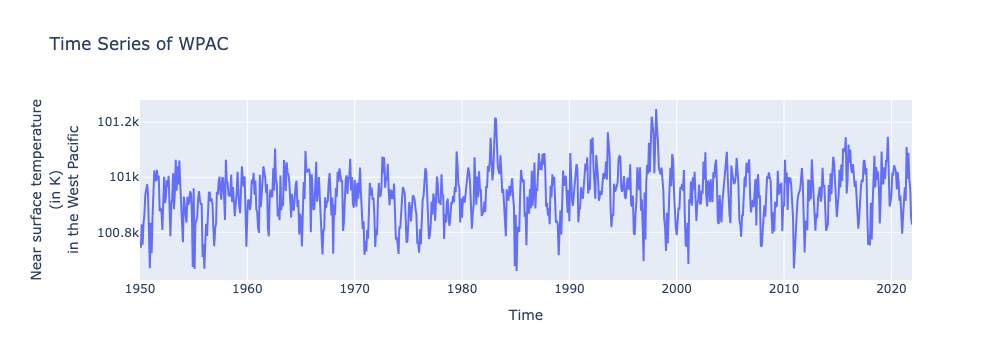

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=WPAC, mode='lines', name='WPAC'))
fig.update_layout(
    title='Time Series of WPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the West Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

## CPAC = Near surface temperature (in K) in the Central Pacific

In [42]:
CPAC = np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [43]:
mean_CPAC = np.mean(CPAC)
std_dev_CPAC = np.std(CPAC)
median_CPAC = np.median(CPAC)
min_val_CPAC = np.min(CPAC)
max_val_CPAC = np.max(CPAC)

print("Mean:", mean_CPAC)
print("Standard Deviation:", std_dev_CPAC)
print("Median:", median_CPAC)
print("Minimum Value:", min_val_CPAC)
print("Maximum Value:", max_val_CPAC)

Mean: 298.8509971064815
Standard Deviation: 0.8447594851404049
Median: 298.91795
Minimum Value: 296.1973
Maximum Value: 300.8865


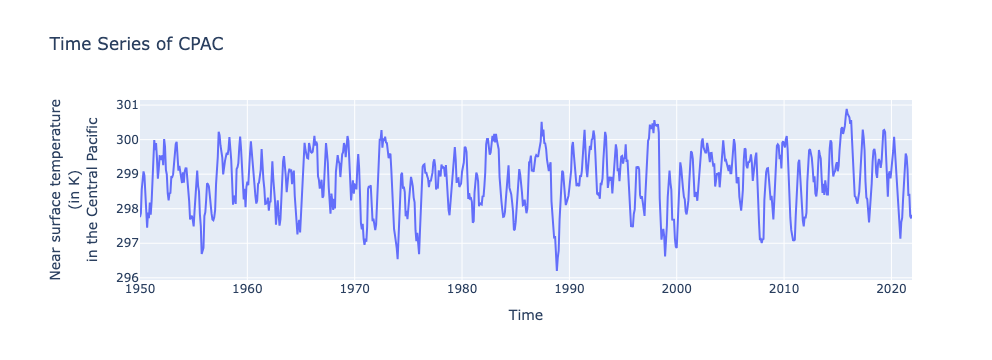

In [44]:
time_index = time_index[:len(CPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=CPAC, mode='lines', name='CPAC'))
fig.update_layout(
    title='Time Series of CPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

## EPAC = Near surface temperature (in K) in the East Pacific

In [45]:
EPAC = np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]

In [46]:
mean_EPAC = np.mean(EPAC)
std_dev_EPAC = np.std(EPAC)
median_EPAC = np.median(EPAC)
min_val_EPAC = np.min(EPAC)
max_val_EPAC = np.max(EPAC)

print("Mean:", mean_EPAC)
print("Standard Deviation:", std_dev_EPAC)
print("Median:", median_EPAC)
print("Minimum Value:", min_val_EPAC)
print("Maximum Value:", max_val_EPAC)

Mean: 296.9792201388889
Standard Deviation: 1.5031017287062765
Median: 296.94034999999997
Minimum Value: 293.807
Maximum Value: 300.8609


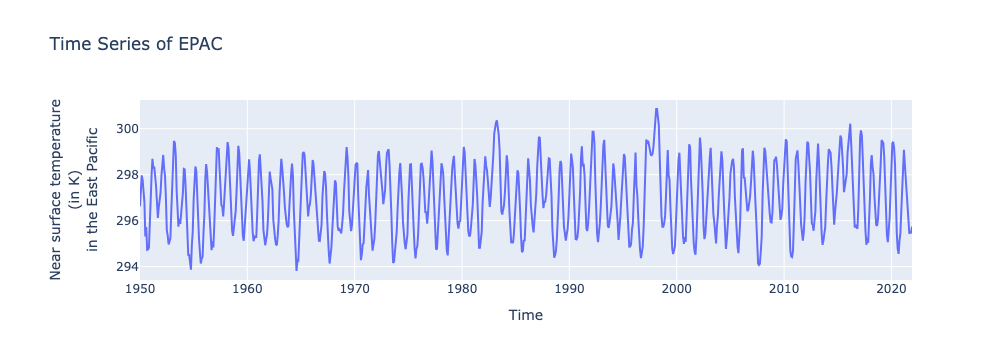

In [47]:
time_index = time_index[:len(EPAC)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=EPAC, mode='lines', name='EPAC'))
fig.update_layout(
    title='Time Series of EPAC',
    xaxis_title='Time',
    yaxis_title='Near surface temperature<br>(in K)<br>in the East Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)
fig.show()

## TW = Near surface winds (in m/s) in the Central Pacific

In [48]:
TW = np.loadtxt('iera5_u10m_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length]
TW *= -1 

In [49]:
mean_TW = np.mean(TW)
std_dev_TW = np.std(TW)
median_TW = np.median(TW)
min_val_TW = np.min(TW)
max_val_TW = np.max(TW)

print("Mean:", mean_TW)
print("Standard Deviation:", std_dev_TW)
print("Median:", median_TW)
print("Minimum Value:", min_val_TW)
print("Maximum Value:", max_val_TW)

Mean: 5.440672281446759
Standard Deviation: 1.0029878863066852
Median: 5.5784445
Minimum Value: -0.3439944
Maximum Value: 7.407164


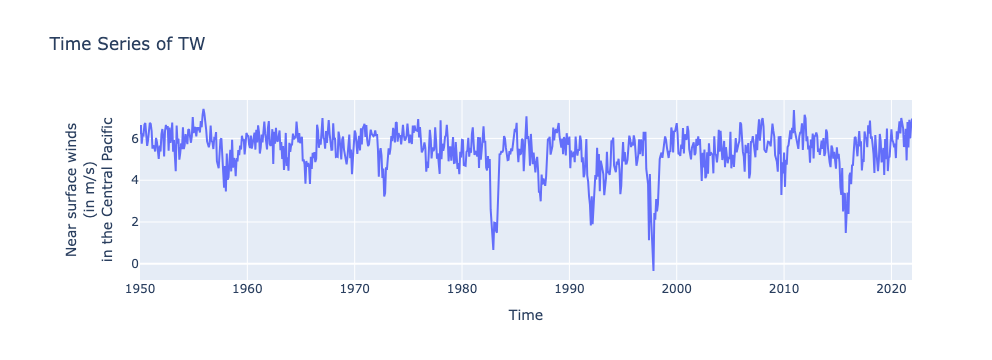

In [50]:
time_index = time_index[:len(TW)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_index, y=TW, mode='lines', name='TW'))

fig.update_layout(
    title='Time Series of TW',
    xaxis_title='Time',
    yaxis_title='Near surface winds<br>(in m/s)<br>in the Central Pacific',
    margin=dict(l=140), 
    yaxis=dict(
        title_standoff=10,
        automargin=True
    )
)

fig.show()

## Extended Dataset and lists

In [51]:
extended_data = np.vstack((
    WPAC,
    CPAC,
    EPAC,
    TW
                )).T

In [52]:
means_climate = [mean_WPAC, mean_CPAC, mean_EPAC, mean_TW]
variances_climate = [(std_dev_WPAC**2), (std_dev_CPAC**2), (std_dev_EPAC**2), (std_dev_TW**2)]

In [53]:
print(means_climate)
print(variances_climate)

[100934.85266203702, 298.8509971064815, 296.9792201388889, 5.440672281446759]
[8764.390455876513, 0.7136185877346819, 2.2593148068397966, 1.005984700077952]


## Detrending and deseazonalizing

In [54]:
def deTrend_deSeasonalize(data, period=12, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=period) # 1 for annual, 12 for monthly, 52 for weekly and 365 for daily
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    #smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        #plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data #- smoothed
        return result

## Full History Reanalysis PCMCI Outcome

In [55]:
def link_robustness_complete_reanalysis(GFDL_data, parcorr, tau_max=3, tau_min=1, extended = 0, info = True, model = 'model'):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
            
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})
            
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results = pcmci_GFDL.run_pcmci(tau_max=tau_max, tau_min=tau_min, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
    # Plot the graph
    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI')
    plt.title(f'Causal networks based on complete history of {model} data', fontsize = 18)
    plt.show()
    
    return results

### The output graph

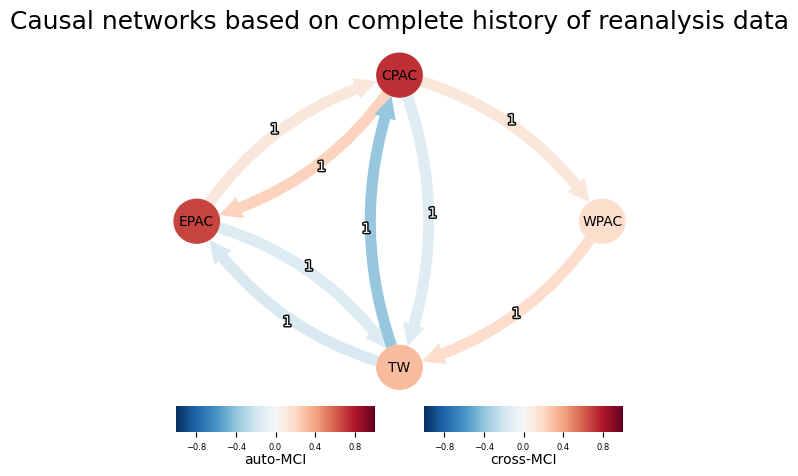

In [71]:
four_node_complete_history_reanalysis_results = link_robustness_complete_reanalysis(extended_data, ParCorr(), tau_max=1, tau_min=1, extended = 1, info = True, model = 'reanalysis')

### The output data

In [72]:
value_matrix = four_node_complete_history_reanalysis_results['val_matrix']

In [73]:
ci_matrix = four_node_complete_history_reanalysis_results['conf_matrix']

For more information, see ComparisonStatistic.ipynb

## Full History Reanalysis Bagging Outcome

In [74]:
df_bagging_climate, dfT_bagging_climate = GenerateDF(extended_data.T, yearly=True)
#def GenerateDF(data, yearly=False, freq='ME', column_names=['WPAC','CPAC','EPAC','TW']):

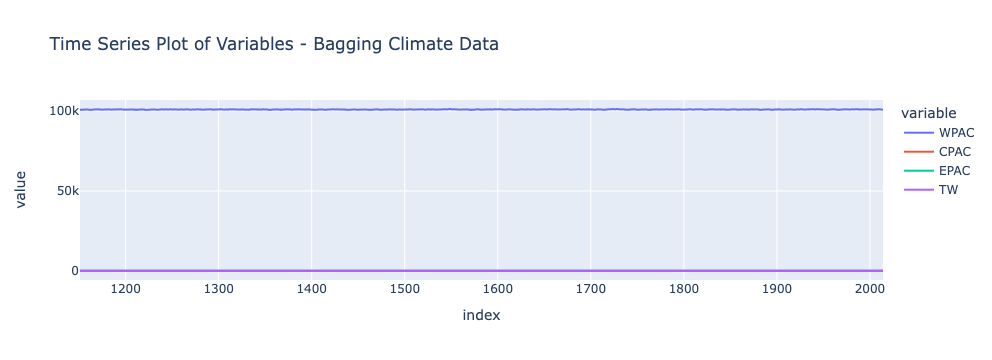

In [75]:
fig = px.line(df_bagging_climate, x=df_bagging_climate.index, y=df_bagging_climate.columns, title='Time Series Plot of Variables - Bagging Climate Data')
fig.show()

### The output graph

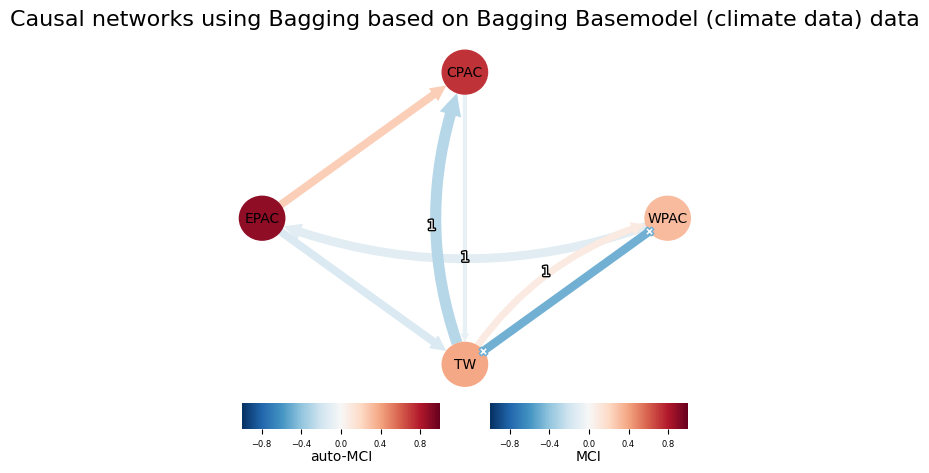

In [76]:
# Run_Bagging(df, tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot=True, model=''):
# Notice that, for better results, we changed the parameters a bit, diverting from the default settings!
results_bagging_climate = Run_Bagging(df_bagging_climate, boot_samples=100,  model='Bagging Basemodel (climate data)') 

### The output data

In [77]:
value_matrix_bagging_climate = results_bagging_climate['summary_results']['val_matrix_mean']
ci_matrix_bagging_climate = results_bagging_climate['summary_results']['val_matrix_interval']

## Correctness Statistics (climate phi)

In [83]:
bagging_cs1 = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_climate, ci_matrix_bagging_climate, 432, means_climate, variances_climate, seed=None)
#new_cs = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 864, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(bagging_cs1)

Monte Carlo Simulations Progress: 100%|██████████| 1000/1000 [2:09:35<00:00,  7.78s/it] 

54.9625


In [84]:
bagging_cs2 = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_climate, ci_matrix_bagging_climate, 864, means_climate, variances_climate, seed=None)
print(bagging_cs2)

Monte Carlo Simulations Progress:   0%|          | 1/1000 [00:12<3:29:39, 12.59s/it]


KeyboardInterrupt: 

In [ ]:
bagging_cs3 = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_climate, ci_matrix_bagging_climate, 2000, means_climate, variances_climate, seed=None)
print(bagging_cs3)

# Basemodel: Random VAR Model

In [59]:
def CompanionFormMatrix(phi, seed=None):
    
    #if seed is not None:
    #    np.random.seed(seed)
    
    p, n, _ = phi.shape
    C = np.zeros((n * p, n * p))

    # Fill in the Phi matrices
    for i in range(p):
        C[:n, i*n:(i+1)*n] = phi[i]

    # Fill in the identity matrices
    for i in range(1, p):
        C[i*n:(i+1)*n, (i-1)*n:i*n] = np.eye(n)
    
    # Check the eigenvalues
    eigenvalues = np.linalg.eigvals(C)
    abs_eigenvalues = np.abs(eigenvalues)
    score = 0
    for i in range(0,len(abs_eigenvalues)):
        if abs_eigenvalues[i] > 1:
                score += 1
    
    if score == 0:
        stability = True
        text = 'The system is stable'
    else:
        stability = False
        text = 'The system is not stable'        
        
    return C, stability, text, abs_eigenvalues

In [60]:
def Generate_VARp_Model(n, p, T, s, beta=0.01, gamma=0.01, diagonal=True, standard=True, constant=False, seed=None):
    """
    This function creates a dataset based on a random VAR(p).
    Note that it follows the definitions of VAR-models from literature: rows are variables.
    
    n: the number of variables
    p: the number of time-lags that the model uses to influence current t
    T: the total number of time-periods in the final dataset
    s: the sparseness of the model; denseness of the edges
    beta: the divergence from zero of the off-diagonal values in Phi        
    gamma: the divergence from one of the diagonal values in Phi
    diagonal: if True, then the diagonal consists of values close to 1 (+/- gamma)
    standard: if True then the error terms are generated by a standard normal process
    constant: if False, then the constant term only consists of zeros
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    "Phi"
    # First we generate a 3D array and run through all of it to assign a 0 or 1
    StableSystem = False
    while StableSystem == False:
        Phi = np.zeros((p, n, n))
        for lag in range(p):            # Run over all lags
            for i in range(n):          # Run over all rows
                for j in range(n):      # Run over all columns
                    Phi[lag, i, j] = np.random.binomial(1,s)
        # Then we run through it again to replace the 1's with a uniform entry
        for lag in range(p):
            for i in range(n):
                for j in range(n):
                    if Phi[lag, i, j] == 1:
                        Phi[lag, i, j] = np.random.uniform(0-beta, 0+beta) #<-- deze was eerste. -1, 1 en 0.02
        # Finally we run through the entries of Phi and make sure the diagonal is 1+the random generated number
        if diagonal == True:
            for t in range(p):
                for i in range(n):
                    for j in range(n):
                        if i==j:
                            Phi[t, i, j] = np.random.uniform(1-gamma, 1+gamma)    #<<-- ineens niet meer stable? ook al zit het in de loop! (deze was 0.05)
        # In the last step we check whether it is a stable system. Otherwise we generate a new one.
        C, stable, stable_text, eigenvalues = CompanionFormMatrix(Phi, seed)
        if stable == True:
            StableSystem = True    
    
    
    "Error term"
    # Make sure we generate from a Gaussian White Noise woth a diagonal covariance matrix
    # We can choose the matrix to be equal to the identity matrix to generate a standard normal distribution 
    # Or we can choose it to be any other diagonal matrix.
    if standard==True:
        Sigma = np.eye(n)
        epsilon = np.random.multivariate_normal(np.zeros(n), Sigma, T).T
    else:
        Sigma = np.diag(np.random.uniform(-1, 1, n))  # Or choose (0, 1, n)!
        epsilon = np.random.multivariate_normal(np.zeros(n), Sigma, T).T 
    
    "Constant term"
    # Set up the constant term, and only fill in the values when constant==True
    if constant==True:
        C = np.random.randn(n, T)
    else:
        C = np.zeros((n, T))
    
    "Time series"
    # Initialize our time series matrix with values at t = 0, ..., p
    # We set the values between 30 and 40 because of reality, but can be chosen randomly
    Y = np.zeros((n,T))
    Y[:, :p] = np.random.uniform(30, 40, (n, p))

    for t in range(p,T):
        for i in range(n):
            Y[i,t] += C[i,t-p]
            # for i = 0 vullen we dus eigenlijk Y_1t, dan vullen we Y_2t, etc. en later gaan we pas naar andere t
            for j in range(1,p+1):
                for k in range(n):
                    Y[i,t] += (Phi[j-1][i,k])*(Y[k,t-j])
            Y[i,t] += epsilon[i,t-p]

    return Y, Phi, Sigma, eigenvalues

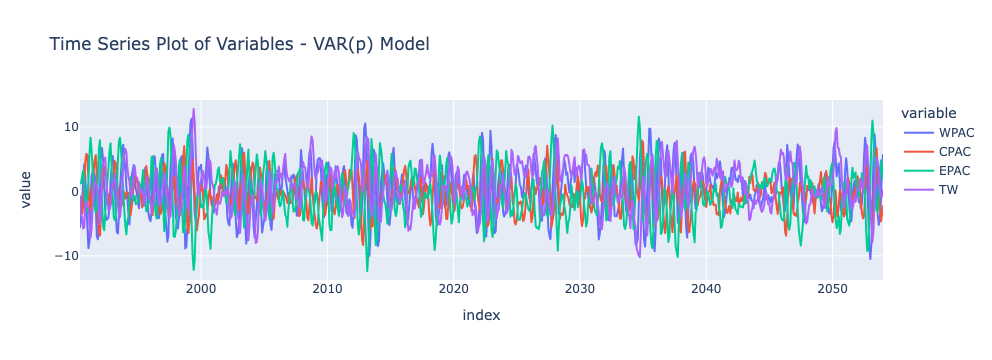

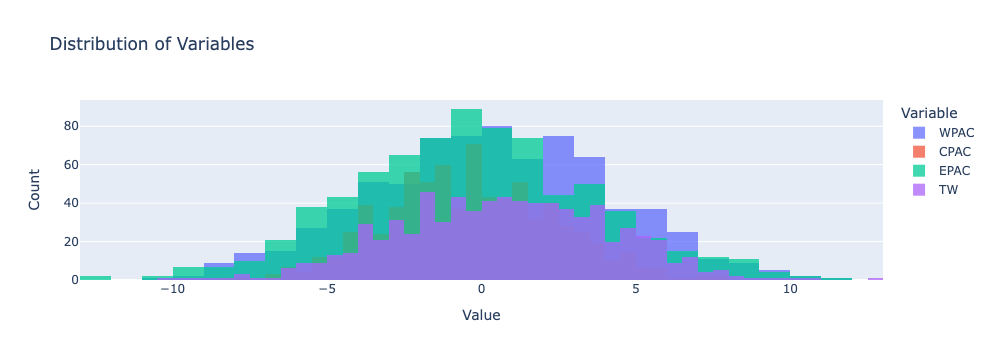

[[[ 0.79034116 -0.56096917  0.29970999  0.        ]
  [ 0.4371717   0.69850643 -0.16777062 -0.38686567]
  [-0.5726033  -0.0828862   0.70228068  0.        ]
  [ 0.39338768  0.          0.09488778  0.79573702]]]


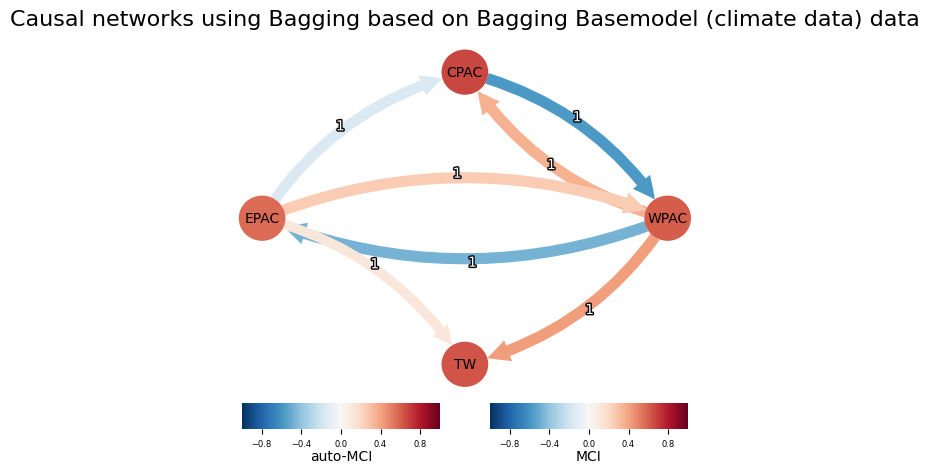

In [61]:
data_VAR, phi_VAR, sigma_VAR, eigenvalues_VAR = Generate_VARp_Model(4, 1, 864, 0.75, beta=0.6, gamma=0.5, diagonal=True, standard=True, constant=False, seed=654)
# Beta: how much do the non-diagonal elements diverge from 0
# Gamma: how much do the diagonal elements diverge from 1
# We generate a VAR model that is similar to the climate data (one lag and 4 variables with 864 observations).


df_VAR_full, dfT_VAR = GenerateDF(data_VAR, 1982)
df_VAR = df_VAR_full[100:]

fig = px.line(df_VAR, x=df_VAR.index, y=df_VAR.columns, title='Time Series Plot of Variables - VAR(p) Model')
fig.show()
fig = go.Figure()
for column in df_VAR.columns:
    fig.add_trace(go.Histogram(x=df_VAR[column], name=column, opacity=0.75))
fig.update_layout(
    barmode='overlay',
    title='Distribution of Variables',
    xaxis_title='Value',
    yaxis_title='Count',
    legend_title='Variable'
)
fig.show()
print(phi_VAR)

mean_WPAC_var = np.mean(data_VAR[0])
mean_CPAC_var = np.mean(data_VAR[1])
mean_EPAC_var = np.mean(data_VAR[2])
mean_TW_var = np.mean(data_VAR[3])
means_VAR = [mean_WPAC_var, mean_CPAC_var, mean_EPAC_var, mean_TW_var]

std_dev_WPAC_var = np.std(data_VAR[0])
std_dev_CPAC_var = np.std(data_VAR[1])
std_dev_EPAC_var = np.std(data_VAR[2])
std_dev_TW_var = np.std(data_VAR[3])

variances_VAR = [(std_dev_WPAC_var**2), (std_dev_CPAC_var**2), (std_dev_EPAC_var**2), (std_dev_TW_var**2)]

# Run_Bagging(df, tau_max=1, boot_samples=200, boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, plot=True, model=''):
# Notice that, for better results, we changed the parameters a bit, diverting from the default settings!
results_bagging_VAR = Run_Bagging(df_VAR, boot_samples=100,  model='Bagging Basemodel (climate data)') 

value_matrix_bagging_VAR = results_bagging_VAR['summary_results']['val_matrix_mean']
ci_matrix_bagging_VAR = results_bagging_VAR['summary_results']['val_matrix_interval']

In [62]:
bagging_cs1_VAR = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_VAR, ci_matrix_bagging_VAR, 432, means_VAR, variances_VAR, seed=None)
#new_cs = CorrectnessStatisticMC(10000, ci_matrix_climate, value_matrix_climate, 864, means_climate, variances_climate, ParCorr(), tau_max=1, tau_min=1, pc_alpha=0.1, alpha_level=0.05)
print(bagging_cs1_VAR)

Monte Carlo Simulations Progress: 100%|██████████| 1000/1000 [1:44:45<00:00,  6.29s/it]

44.525


In [63]:
bagging_cs2_VAR = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_VAR, ci_matrix_bagging_VAR, 864, means_VAR, variances_VAR, seed=None)
print(bagging_cs2_VAR)

Monte Carlo Simulations Progress: 100%|██████████| 1000/1000 [1:44:46<00:00,  6.29s/it]

44.66875


In [64]:
bagging_cs3_VAR = CorrectnessStatisticMCbagging(1000, value_matrix_bagging_VAR, ci_matrix_bagging_VAR, 2000, means_VAR, variances_VAR, seed=None)
print(bagging_cs3_VAR)

Monte Carlo Simulations Progress: 100%|██████████| 1000/1000 [1:45:20<00:00,  6.32s/it]

44.43125


# Results: Monte Carlo Simulations of Climate Data

Now we use the function that combines all functions and put the val_matrix and confidence interval matrix in from the climate data to compare our results to those.

MonteCarlo_CSgraph(mean_val_matrix, ci_matrix, initial_mean, initial_var, M, intervals=50, min_T=50, 
                            max_T=10000, constant_term=False, standard_error_distribution=True, yearly=False, 
                            freq='ME', column_names=['WPAC','CPAC','EPAC','TW'], tau_max=1, boot_samples=200, 
                            boot_blocklength=1, test=ParCorr(), pc_alpha_bootstrap=0.05, pc_alpha=None, seed=None):

returns: 
     MCstatistics, fig, dataframes, seeds

loading... 100.0%


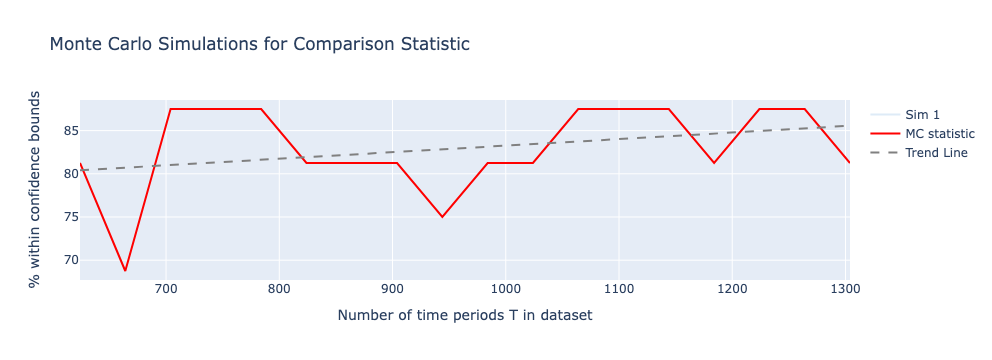

In [105]:
# M=1
MCstatistics_bagging_climate, MCfig_bagging_climate, MCdfs_bagging_climate, MCseeds_bagging_climate = MonteCarlo_CSgraph(value_matrix_bagging_climate, ci_matrix_bagging_climate, 
                                                                                                                         means_climate, variances_climate, 1, intervals=40, min_T=624, max_T=1344)
# Should take about 4.5 minutes

loading... 2.0%
loading... 4.0%
loading... 6.0%
loading... 8.0%
loading... 10.0%
loading... 12.0%
loading... 14.0%
loading... 16.0%
loading... 18.0%
loading... 20.0%
loading... 22.0%
loading... 24.0%
loading... 26.0%
loading... 28.0%
loading... 30.0%
loading... 32.0%
loading... 34.0%
loading... 36.0%
loading... 38.0%
loading... 40.0%
loading... 42.0%
loading... 44.0%
loading... 46.0%
loading... 48.0%
loading... 50.0%
loading... 52.0%
loading... 54.0%
loading... 56.0%
loading... 58.0%
loading... 60.0%
loading... 62.0%
loading... 64.0%
loading... 66.0%
loading... 68.0%
loading... 70.0%
loading... 72.0%
loading... 74.0%
loading... 76.0%
loading... 78.0%
loading... 80.0%
loading... 82.0%
loading... 84.0%
loading... 86.0%
loading... 88.0%
loading... 90.0%
loading... 92.0%
loading... 94.0%
loading... 96.0%
loading... 98.0%
loading... 100.0%


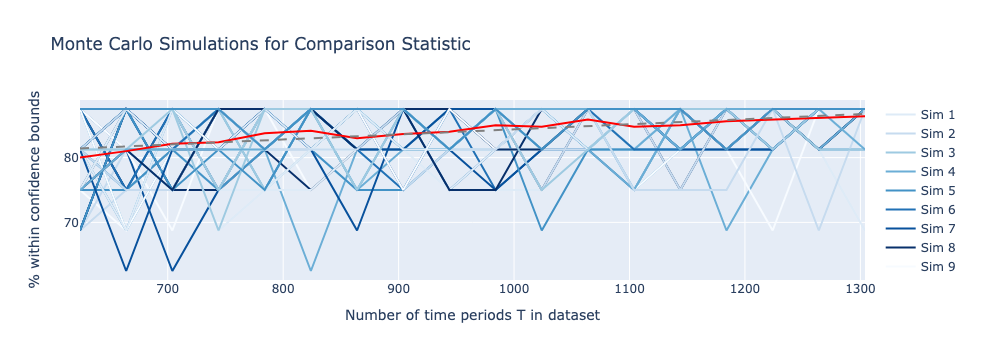

In [106]:
# M=50
MCstatistics_bagging_climate, MCfig_bagging_climate, MCdfs_bagging_climate, MCseeds_bagging_climate = MonteCarlo_CSgraph(value_matrix_bagging_climate, ci_matrix_bagging_climate, 
                                                                                                                         means_climate, variances_climate, 50, intervals=40, min_T=624, max_T=1344)
# WARNING: Takes a long time to run! (with 50 simulations it would take about 3 hours and 15 minutes)

# Results: Monte Carlo Simulations of Random VAR Model